In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [36]:
# MySQL Connector
import mysql.connector
database = mysql.connector.connect(
    user='root', password='jarvis@admin', host='192.168.1.97', port='3306')
cursor = database.cursor()

In [2]:
deva_images_list = tf.data.Dataset.list_files('data/Devasheesh/*.jpg', shuffle=True)
swar_images_list = tf.data.Dataset.list_files('data/Swarnim/*.jpg', shuffle=True)
neg_images_list = tf.data.Dataset.list_files('data/Unknown/*/*.jpg', shuffle=True)

# combine all the images into one dataset
images_list = deva_images_list.concatenate(swar_images_list).concatenate(neg_images_list)

# shuffle the dataset
images_list = images_list.shuffle(buffer_size=1000)

In [3]:
#! see values inside variables
# for i in images_list.take(5):
#     print(i.numpy())

# print(len(images_list))
print(type(images_list))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [74]:
# take the image path and return the label
def get_label(image_path):
    # parts = tf.strings.split(image_path, os.path.sep)
    print(image_path.numpy().decode('utf-8'))
    if parts[1] == 'Devasheesh':
        return [0, 1, 0],  f"{parts[2].numpy().decode('utf-8')}/{parts[3].numpy().decode('utf-8')}".split(".")[0]
        # return 'devasheesh'
    elif parts[1] == 'Swarnim':
        return [0, 0, 1],  parts[2]+parts[3].split('.')[0]
        # return 'swarnim'
    elif parts[1] == 'Unknown':
        return [1, 0, 0],  parts[2]+parts[3].split('.')[0]
        # return 'unknown'
    # else:
    #     return [0, 0, 0],  parts[2]+parts[3].split('.')[0]
        # return 'unknown'


In [67]:
get_label('data/Devasheesh/n000029/0145_01.jpg')


([0, 1, 0], 'n000029/0145_01')

In [ ]:
def extract_face_sql(path, table='VGG_Face2_TEST', cursor = cursor):
    X, Y, W, H = cursor.execute(
        f"SELECT X, Y, W, H FROM {table}`.`face` WHERE `PATH` = '{path}'")
    return X, Y, W, H


In [68]:
# takes the image path and returns the the face as a tensor
def preprocess_image(image_path):
    label, path = get_label(image_path)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [360, 480])
    # ? extract the face from the image using dataframe
    X, Y, W, H = extract_face_sql(path)
    
    face = tf.image.crop_to_bounding_box(image, X, Y, W, H)
    
    face = tf.cast(face, tf.float32)
    return face / 255.0, label
    # return image

In [27]:
image_path, face, label = preprocess_image('data/Unknown/n000029/0145_01.jpg')
image_path

# image.numpy().shape
# print(type(preprocess_image('data\\Unknown\\n000029\\0145_01.jpg')))
# plt.imshow(image, cmap='gray')
# plt.title(label)
# image

'data/Unknown/n000029/0145_01.jpg'

In [75]:
# dataset object

# Define a generator function that yields each file path
# def generator():
#     for filepath in images_list:
#         yield filepath

# dataset = tf.data.Dataset.from_generator(generator, output_types=tf.string)
# print(dataset)
dataset = images_list.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

AttributeError: in user code:

    File "/tmp/ipykernel_8044/2693383212.py", line 3, in preprocess_image  *
        label = get_label(image_path)
    File "/tmp/ipykernel_8044/3692295203.py", line 4, in get_label  *
        print(image_path.numpy().decode('utf-8'))

    AttributeError: 'Tensor' object has no attribute 'numpy'


<class 'tuple'>


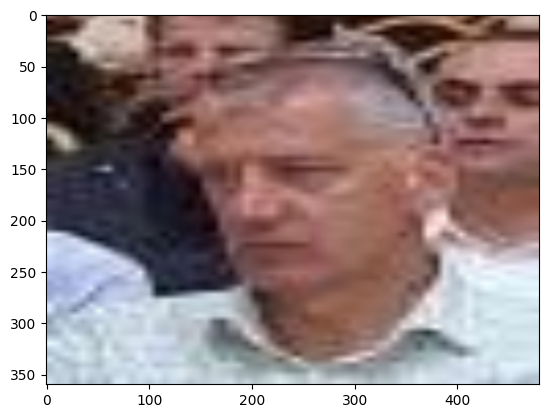

<class 'tuple'>


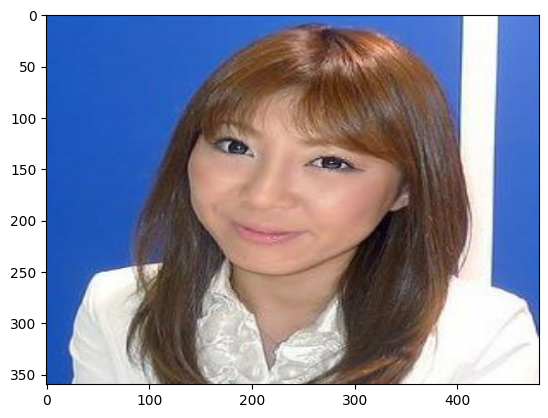

<class 'tuple'>


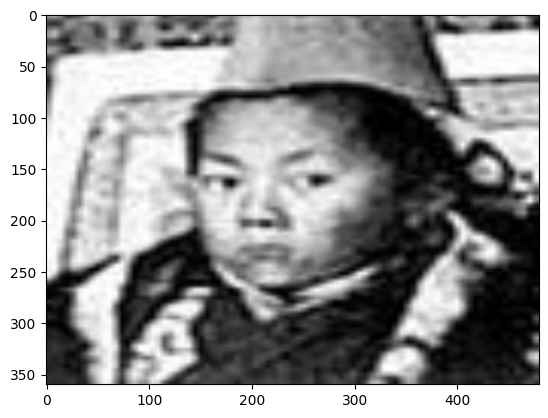

In [19]:
for img, label in dataset.take(3):
    # print(img.shape)
    plt.imshow(img, cmap='gray')
    # print(type(label))
    plt.title(label)
    plt.show()